In [610]:
import pandas as pd
pd.set_option('display.max_columns', 40)
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier, SGDRegressor

import matplotlib.pyplot as plt

# Hong Kong horse race prediction models

This notebook runs through various models which will predict the outcome of horse races in Hong Kong. Different types of models will be trained, along with different hyperparameters, in order to produce the best possible model. The best model and its hyperparameters will then be saved as a separate python script, which will allow us to easily pass new data through and make predictions.

## 1. Loading and splitting dataset

The data set being used here is the _Hong Kong horse racing_ dataset. Please see the EDA.ipynb file (in the src directory) and README for a more in depth description of this dataset.

In [633]:
training_data = pd.read_csv("../data/data_train.csv")
training_data.head()

,Unnamed: 0,row,plc,horseno,horse,jockey,trainer_x,actualwt,declarwt,draw,lbw,runningpos,finishtime,winodds,date,raceno,class,distance,going,handicap,course,stake,venue,dataset,gear,comment,result,country,colour,sex,owner,import_type,current_rating,start_rating,sire,dam,age
0,21818,NaN,3,NaN,SPICY KAKA(V323),K Teetan,J Moore,NaN,NaN,2.0,2-1/2L,2 2 3,1.11.40,NaN,2016-07-05,1,NaN,1200,WET,NaN,ALL WEATHER TRACK,NaN,SHA TIN,barrier,B,Slow to begin; raced greenly.,Passed,GB,Bay,Gelding,Kathleen Shi Pui Ka,ISG,57.0,51.0,Excellent Art,Cheap Thrills,5.0
1,7569,6.0,7,9.0,DIAMOND MASTER(S397),K C Leung,P F Yiu,116.0,1156.0,8.0,4-1/2,3 2 7,1.09.61,39.0,2016-04-16,8,3.0,1200,GOOD TO FIRM,THE SPORTS WITHOUT BORDERS HANDICAP,TURF - C+3 COURSE,1165000.0,Sha Tin,results,B/XB,"In pursuit of leader, held 2nd till 250M, no e...",NaN,AUS,Bay,Gelding,HK Diamond Bourse Racing Syndicate,PPG,68.0,69.0,Not A Single Doubt,Sandy Desert,6.0
2,12339,11.0,12,5.0,TARZAN I AM(P299),C Y Ho,D Cruz,125.0,1224.0,14.0,12,6 9 12,1.11.19,21.0,2015-06-14,3,4.0,1200,GOOD TO FIRM,CARL F. BUCHERER HANDICAP,TURF - B+2 COURSE,760000.0,Sha Tin,results,TT,"Camped handy, however trapped 4 wide without c...",NaN,NZ,Bay,Gelding,Fok Yuk Tong,PP,NaN,NaN,Darci Brahma,Climb The Vine,NaN
3,12719,11.0,12,4.0,AIMING HIGH(V206),M L Yeung,T P Yung,124.0,1149.0,8.0,19,11 11 12,1.13.11,32.0,2016-04-13,6,3.0,1200,GOOD TO YIELDING,MATHESON HANDICAP,TURF - A COURSE,1165000.0,Happy Valley,results,H,"At rear throughout, never in contention. ...",NaN,NZ,Bay,Gelding,"Terence Leung Chi Kin, Patrick Wong Man Kam, J...",PP,NaN,NaN,Captain Rio,Kiwi Supreme,NaN
4,8117,7.0,8,6.0,PLANET STAR(A049),S de Sousa,P O'Sullivan,125.0,1182.0,6.0,5-1/2,7 8 8,1.10.70,7.7,2017-01-14,3,4.0,1200,GOOD,HO SHEUNG HEUNG HANDICAP,TURF - C+3 COURSE,840000.0,Sha Tin,results,--,"Raced midfield, 6Ls behind the leader 3 wide w...",NaN,AUS,Brown,Gelding,Planet Racing Syndicate,PPG,50.0,52.0,Denman,Tell Someone,4.0


Before we split, we want to drop all rows which don't have a finishtime, since we need targets to train our models. We will use the `time_parser` function below to convert time string to seconds.

In [634]:
def time_parser(input_time):
    """
    Function which converts a time string of form mm.ss.SS to seconds
    
    Arguments:
    input_time (str) - input time as string of form "d.dd.dd" where d is a digit

    Returns:
    float representing input time in seconds
    """
    
    parsed_time = input_time.split(".")
    mins = int(parsed_time[0])
    secs = int(parsed_time[1])
    ss = int(parsed_time[2])
    
    time_in_sec = mins*60.0 + secs + ss/100
    return time_in_sec

In [635]:
targets = training_data["finishtime"]
#fill nans with "0.00.00"
targets.fillna("0.00.00", inplace=True)       
#replace anything not of format d.dd.dd to "0.00.00"
targets[~targets.str.contains("\d\.\d{2}\.\d{2}")] = '0.00.00'
#apply time_parser on all values
targets = np.array(list(map(lambda x: time_parser(x), targets)))
#replace target column with converted values
training_data["finishtime"] = targets
#drop all rows where finishtime is 0.0
training_data = training_data[training_data["finishtime"] != 0.0]

/Users/robertblumberg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Unnamed: 0,row,plc,horseno,horse,jockey,trainer_x,actualwt,declarwt,draw,lbw,runningpos,finishtime,winodds,date,raceno,class,distance,going,handicap,course,stake,venue,dataset,gear,comment,result,country,colour,sex,owner,import_type,current_rating,start_rating,sire,dam,age
0,21818,NaN,3,NaN,SPICY KAKA(V323),K Teetan,J Moore,NaN,NaN,2.0,2-1/2L,2 2 3,71.40,NaN,2016-07-05,1,NaN,1200,WET,NaN,ALL WEATHER TRACK,NaN,SHA TIN,barrier,B,Slow to begin; raced greenly.,Passed,GB,Bay,Gelding,Kathleen Shi Pui Ka,ISG,57.0,51.0,Excellent Art,Cheap Thrills,5.0
1,7569,6.0,7,9.0,DIAMOND MASTER(S397),K C Leung,P F Yiu,116.0,1156.0,8.0,4-1/2,3 2 7,69.61,39.0,2016-04-16,8,3.0,1200,GOOD TO FIRM,THE SPORTS WITHOUT BORDERS HANDICAP,TURF - C+3 COURSE,1165000.0,Sha Tin,results,B/XB,"In pursuit of leader, held 2nd till 250M, no e...",NaN,AUS,Bay,Gelding,HK Diamond Bourse Racing Syndicate,PPG,68.0,69.0,Not A Single Doubt,Sandy Desert,6.0
2,12339,11.0,12,5.0,TARZAN I AM(P299),C Y Ho,D Cruz,125.0,1224.0,14.0,12,6 9 12,71.19,21.0,2015-06-14,3,4.0,1200,GOOD TO FIRM,CARL F. BUCHERER HANDICAP,TURF - B+2 COURSE,760000.0,Sha Tin,results,TT,"Camped handy, however trapped 4 wide without c...",NaN,NZ,Bay,Gelding,Fok Yuk Tong,PP,NaN,NaN,Darci Brahma,Climb The Vine,NaN
3,12719,11.0,12,4.0,AIMING HIGH(V206),M L Yeung,T P Yung,124.0,1149.0,8.0,19,11 11 12,73.11,32.0,2016-04-13,6,3.0,1200,GOOD TO YIELDING,MATHESON HANDICAP,TURF - A COURSE,1165000.0,Happy Valley,results,H,"At rear throughout, never in contention. ...",NaN,NZ,Bay,Gelding,"Terence Leung Chi Kin, Patrick Wong Man Kam, J...",PP,NaN,NaN,Captain Rio,Kiwi Supreme,NaN
4,8117,7.0,8,6.0,PLANET STAR(A049),S de Sousa,P O'Sullivan,125.0,1182.0,6.0,5-1/2,7 8 8,70.70,7.7,2017-01-14,3,4.0,1200,GOOD,HO SHEUNG HEUNG HANDICAP,TURF - C+3 COURSE,840000.0,Sha Tin,results,--,"Raced midfield, 6Ls behind the leader 3 wide w...",NaN,AUS,Brown,Gelding,Planet Racing Syndicate,PPG,50.0,52.0,Denman,Tell Someone,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18739,10955,9.0,10,6.0,STARSHIP(V379),D Lane,P O'Sullivan,126.0,1132.0,8.0,4-3/4,9 8 7 10,94.97,22.0,2016-11-27,9,3.0,1600,GOOD,CHEVALIER LIFTS & ESCALATORS HANDICAP,TURF - C COURSE,1235000.0,Sha Tin,results,--,No early pace and shuffled back to midfield bu...,NaN,AUS,Chestnut,Gelding,David Sin Wai Kin,PP,66.0,67.0,Husson,Ourkohinoor,5.0
18740,17289,NaN,1,NaN,GIANT TREASURE(T148),K C Leung,R Gibson,NaN,NaN,5.0,NaN,2 2 1,70.42,NaN,2016-04-19,1,NaN,1200,GOOD,NaN,ALL WEATHER TRACK,NaN,SHA TIN,barrier,B/H,Under restraint early; won well when let go.,NaN,USA,Grey,Gelding,Pan Sutong,PP,115.0,117.0,Mizzen Mast,Palisade,7.0
18741,5192,4.0,5,4.0,FORMULA WON(P183),B Prebble,C Fownes,130.0,1039.0,11.0,3,9 7 9 5,102.13,12.0,2015-10-22,7,3.0,1650,GOOD,SHEK UK SHAN HANDICAP,TURF - C+3 COURSE,1165000.0,Happy Valley,results,TT,"Shifted across behind runners from wide draw, ...",NaN,IRE,Chestnut,Gelding,Lillian Lee Lai Man & Kenny Tse Chiu Ping,PP,NaN,NaN,Dutch Art,Paix Royale,NaN
18742,12172,11.0,12,12.0,DELIGHT FORTUNE(N402),T H So,L Ho,111.0,1068.0,6.0,10-1/4,11 11 12,59.14,31.0,2016-04-13,1,5.0,1000,GOOD TO YIELDING,EAST POINT HANDICAP,TURF - A COURSE,600000.0,Happy Valley,results,SR/V,"Soon dropped to the rear, made no show. ...",NaN,GB,Bay,Gelding,William Sze Loong Yau,PP,NaN,NaN,Striking Ambition,Concentration,NaN


In [636]:
X_train, X_test, y_train, y_test = train_test_split(training_data.drop("finishtime", axis=1), training_data["finishtime"], test_size=0.2)

## 2. Data preprocessing

Here, we make pipeline to process the numeric and categorical features.

The numeric features will be processed by replacing nan's with the mean value of that feature. this will be done using `SimpleImputer`.

The categorical features will be processed by replacing nan's with "not_specified". They will also be one-hot encoded.

Then, we will combine the two preprocessing pipelines.

In [644]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

#define preprocessor for numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                      ('poly', PolynomialFeatures())])

#define preprocessor for categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value="not_specified")),
                                          ('one_hot_encoder',  OneHotEncoder())
                                         ])

#combine numeric and categorical pipelines
categorical_features = ["country", "dataset"]
numeric_features = ["declarwt", "age", "winodds", "stake", "distance"]

preprocessing = ColumnTransformer(
                                 transformers=[
                                    ('num', numeric_transformer, numeric_features),
                                    ('cat', categorical_transformer, categorical_features)
                                ])

#combine preprocessing and model fitting steps into one pipeline 
full_pipeline = Pipeline([
    ('data_preprocessing', preprocessing)
])

X_train_preprocessed = full_pipeline.fit_transform(X_train)
X_test_preprocessed = full_pipeline.transform(X_test)
X_train_preprocessed

array([[1.00000000e+00, 1.10888807e+03, 5.96494180e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.10888807e+03, 6.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.13000000e+03, 6.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [1.00000000e+00, 1.26900000e+03, 5.96494180e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.10888807e+03, 6.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.08700000e+03, 5.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

## 3. Fitting models

### 3.1 Simple linear regression

In [645]:
lr = LinearRegression()

In [646]:
lr.fit(X_train_preprocessed, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [647]:
test_results = pd.DataFrame({"Actual finish time" : y_test,
                             "Predicted finish time" : lr.predict(X_test_preprocessed)})
test_results

,Actual finish time,Predicted finish time
7107,100.17,96.614367
12991,100.36,96.882531
8509,148.65,150.362846
12512,59.08,64.016228
14644,101.59,96.350983
...,...,...
17555,72.57,70.625646
5418,58.91,64.670727
203,100.69,97.796954
9777,81.89,80.045054


Text(0, 0.5, 'Actual finish time')

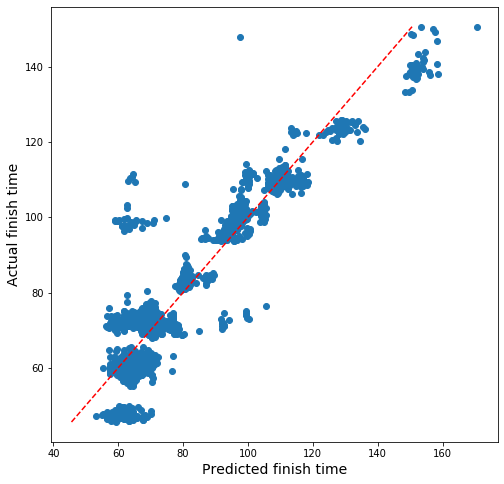

In [648]:
fig, ax = plt.subplots(1, 1, figsize = (8 ,8))
ax.scatter(test_results["Predicted finish time"], test_results["Actual finish time"])
ax.plot([min(test_results["Actual finish time"]), max(test_results["Actual finish time"])],
        [min(test_results["Actual finish time"]), max(test_results["Actual finish time"])], 
        linestyle = "--", color = "red")
ax.set_xlabel("Predicted finish time", size=14)
ax.set_ylabel("Actual finish time", size=14)